Step 1: Imports and Setup

In [4]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from collections import defaultdict
from math import sqrt
from surprise import Dataset, Reader, SVD, NMF, KNNBasic
from surprise.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
# For display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

Step 2: Load MovieLens Dataset

In [6]:
# # Load ratings and movies metadata
# ratings_df = pd.read_csv("movielens/ratings.csv")     # userId, movieId, rating, timestamp
# movies_df = pd.read_csv("movielens/movies.csv")       # movieId, title, genres

ratings_df = pd.read_csv("movielens/ratings.csv")  # user_id, movie_id, user_rating, timestamp
movies_df = pd.read_csv("movielens/movies.csv")    # movie_id, movie_title, movie_genres, poster_url

# Rename columns to standardize
ratings_df.rename(columns={"user_id": "userId", "movie_id": "movieId", "user_rating": "rating"}, inplace=True)
movies_df.rename(columns={"movie_id": "movieId", "movie_title": "title", "movie_genres": "genres"}, inplace=True)

# Merge for content-based filtering
merged_df = pd.merge(ratings_df, movies_df, on="movieId")
ratings_df = merged_df[['userId', 'movieId', 'rating']]


# Merge metadata for content-based work in Week 3
merged_df = pd.merge(ratings_df, movies_df, on="movieId")

# Check for nulls
print("Missing values:\n", merged_df.isnull().sum())

# Drop unnecessary columns for now
ratings_df = merged_df[['userId', 'movieId', 'rating']]

Missing values:
 userId           0
movieId          0
rating           0
title            0
genres           0
poster_url    6554
dtype: int64


Step 3: EDA

C:\Users\user\AppData\Local\Temp\ipykernel_2424\1197399879.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="viridis")


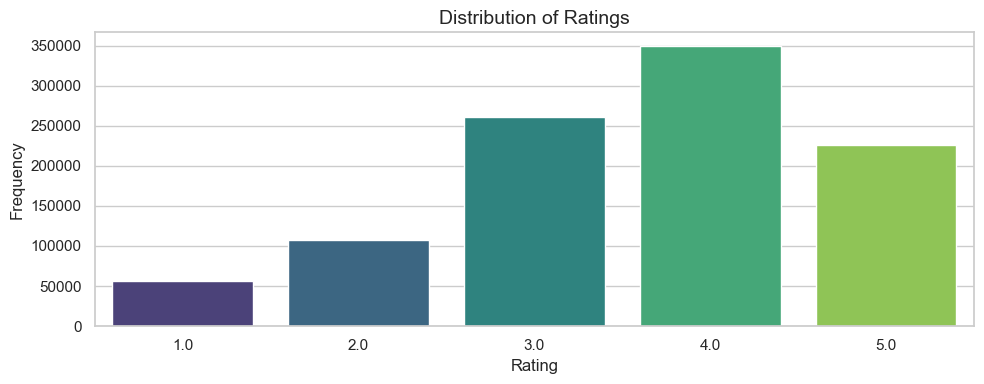

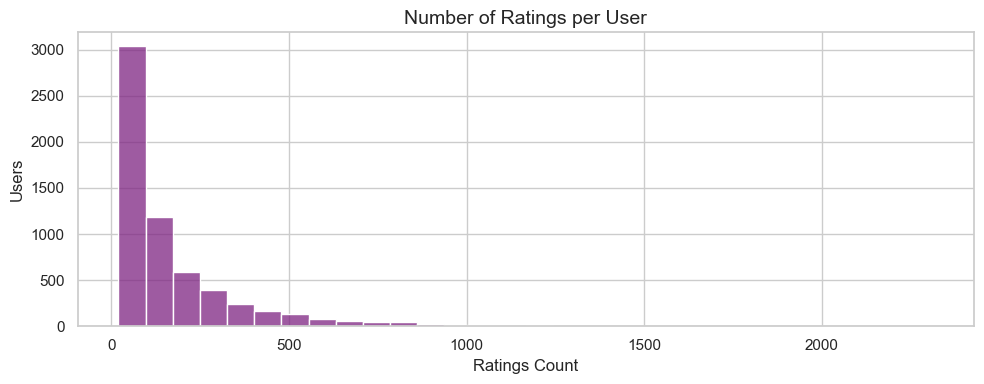

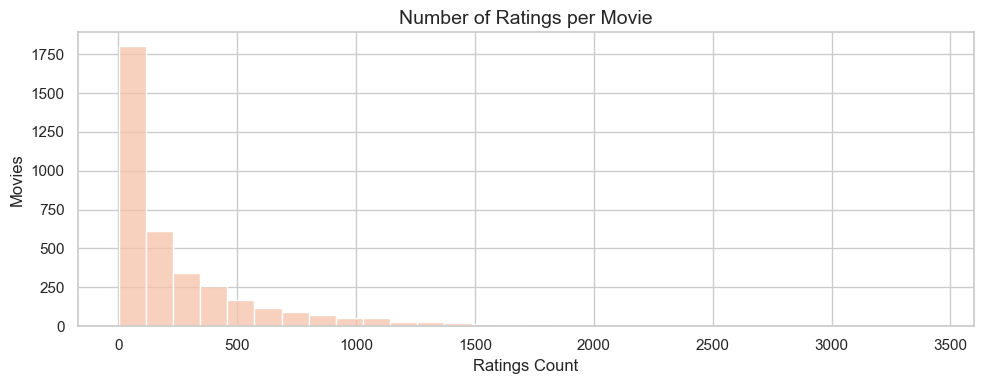

C:\Users\user\AppData\Local\Temp\ipykernel_2424\1197399879.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', data=ratings_df, palette="Set2")


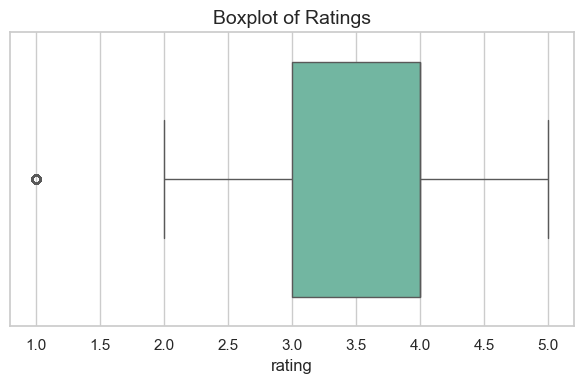

Outlier Ratings (not between 1 and 5):
Empty DataFrame
Columns: [userId, movieId, rating]
Index: []


In [7]:
# --- Rating Distribution ---
rating_counts = ratings_df['rating'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="viridis")
plt.title("Distribution of Ratings", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Ratings per user
ratings_per_user = ratings_df.groupby('userId')['rating'].count()
plt.figure(figsize=(10, 4))
sns.histplot(ratings_per_user, bins=30, kde=False, color=sns.color_palette("magma", 10)[3])
plt.title("Number of Ratings per User", fontsize=14)
plt.xlabel("Ratings Count")
plt.ylabel("Users")
plt.tight_layout()
plt.show()

# Ratings per movie
ratings_per_movie = ratings_df.groupby('movieId')['rating'].count()
plt.figure(figsize=(10, 4))
sns.histplot(ratings_per_movie, bins=30, kde=False, color=sns.color_palette("coolwarm", 10)[6])
plt.title("Number of Ratings per Movie", fontsize=14)
plt.xlabel("Ratings Count")
plt.ylabel("Movies")
plt.tight_layout()
plt.show()



# --- Boxplot for Ratings ---
plt.figure(figsize=(6, 4))
sns.boxplot(x='rating', data=ratings_df, palette="Set2")
plt.title("Boxplot of Ratings", fontsize=14)
plt.tight_layout()
plt.show()

# --- Print Outliers ---
print("Outlier Ratings (not between 1 and 5):")
print(ratings_df[(ratings_df['rating'] < 1) | (ratings_df['rating'] > 5)])

Load and Train the 4 Models

In [8]:

if not os.path.exists("svd_model.pkl"):
    print("Model file not found. Training models now...")

    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

    # Train models
    user_knn = KNNBasic(sim_options={'user_based': True})
    user_knn.fit(trainset)
    user_preds = user_knn.test(testset)

    item_knn = KNNBasic(sim_options={'user_based': False})
    item_knn.fit(trainset)
    item_preds = item_knn.test(testset)

    svd_model = SVD()
    svd_model.fit(trainset)
    svd_preds = svd_model.test(testset)

    nmf_model = NMF()
    nmf_model.fit(trainset)
    nmf_preds = nmf_model.test(testset)

    # Save models
    with open("svd_model.pkl", "wb") as f:
        pickle.dump(svd_model, f)
    with open("nmf_model.pkl", "wb") as f:
        pickle.dump(nmf_model, f)
    with open("user_knn.pkl", "wb") as f:
        pickle.dump(user_knn, f)
    with open("item_knn.pkl", "wb") as f:
        pickle.dump(item_knn, f)
    with open("trainset.pkl", "wb") as f:
        pickle.dump(trainset, f)

else:
    print("Loading pre-trained models...")
    with open("svd_model.pkl", "rb") as f:
        svd_model = pickle.load(f)
    with open("nmf_model.pkl", "rb") as f:
        nmf_model = pickle.load(f)
    with open("user_knn.pkl", "rb") as f:
        user_knn = pickle.load(f)
    with open("item_knn.pkl", "rb") as f:
        item_knn = pickle.load(f)
    with open("trainset.pkl", "rb") as f:
        trainset = pickle.load(f)

Model file not found. Training models now...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


Step 4: Prepare Surprise Dataset

In [9]:
# Recreate testset
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
_, testset = train_test_split(data, test_size=0.2, random_state=42)

user_preds = user_knn.test(testset)
item_preds = item_knn.test(testset)
svd_preds = svd_model.test(testset)
nmf_preds = nmf_model.test(testset)

Step 5: Collaborative Filtering Models

In [10]:
# User-Based Collaborative Filtering
user_knn = KNNBasic(sim_options={'user_based': True})
user_knn.fit(trainset)
user_preds = user_knn.test(testset)

# Item-Based Collaborative Filtering
item_knn = KNNBasic(sim_options={'user_based': False})
item_knn.fit(trainset)
item_preds = item_knn.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


Step 6: Evaluation Functions

In [11]:
def calculate_rmse(preds):
    return sqrt(mean_squared_error([pred.r_ui for pred in preds], [pred.est for pred in preds]))

def calculate_mae(preds):
    return mean_absolute_error([pred.r_ui for pred in preds], [pred.est for pred in preds])

def precision_at_k(predictions, k=5, threshold=3.5):
    user_est_true = defaultdict(list)
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))
    precisions = []
    for user, ratings in user_est_true.items():
        ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = ratings[:k]
        relevant = sum((true_r >= threshold) for (_, true_r) in top_k)
        precisions.append(relevant / k)
    return np.mean(precisions)


Step 7: Evaluation Results

In [12]:
def print_metrics(name, predictions):
    rmse = calculate_rmse(predictions)
    mae = calculate_mae(predictions)
    precision = precision_at_k(predictions, k=5)
    print(f"\n===== {name} Evaluation =====")
    print(f"RMSE       : {rmse:.4f}")
    print(f"MAE        : {mae:.4f}")
    print(f"Precision@5: {precision:.4f}")

# Evaluate all models
print_metrics("User-Based Collaborative Filtering", user_preds)
print_metrics("Item-Based Collaborative Filtering", item_preds)
print_metrics("SVD Matrix Factorization", svd_preds)
print_metrics("NMF Matrix Factorization", nmf_preds)


===== User-Based Collaborative Filtering Evaluation =====
RMSE       : 0.9212
MAE        : 0.7255
Precision@5: 0.7776

===== Item-Based Collaborative Filtering Evaluation =====
RMSE       : 0.9127
MAE        : 0.7177
Precision@5: 0.7861

===== SVD Matrix Factorization Evaluation =====
RMSE       : 0.8720
MAE        : 0.6836
Precision@5: 0.7923

===== NMF Matrix Factorization Evaluation =====
RMSE       : 0.9166
MAE        : 0.7237
Precision@5: 0.7631


Step 8: Content-Based Filtering using TF-IDF (Genres)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Step 9.1: TF-IDF on Genres
movies_df['genres'] = movies_df['genres'].fillna("")
tfidf = TfidfVectorizer(token_pattern=r"(?u)\b[\w-]+\b")
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])

# Step 9.2: Cosine Similarity Matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Step 9.3: Map indices to movie titles
indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()

# Step 9.4: Content-based recommendation function
def get_content_recommendations(title, top_n=10):
    idx = indices.get(title)
    if idx is None:
        return pd.DataFrame([f"No such movie: {title}"])
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    movie_indices = [i[0] for i in sim_scores[1:top_n+1]]
    
    return movies_df.iloc[movie_indices][['title', 'genres']]

# Example usage
print("\n🎬 Content-Based Recommendations for 'Toy Story (1995)':")
print(get_content_recommendations("Toy Story (1995)"))


🎬 Content-Based Recommendations for 'Toy Story (1995)':
                                               title   genres
160                                 Toy Story (1995)  2, 3, 4
243                               Chicken Run (2000)  2, 3, 4
606                               Toy Story 2 (1999)  2, 3, 4
984                         American Tail, An (1986)  2, 3, 4
1194                            Bug's Life, A (1998)  2, 3, 4
1474          Aladdin and the King of Thieves (1996)  2, 3, 4
1635                       Rugrats Movie, The (1998)  2, 3, 4
1983  Adventures of Rocky and Bullwinkle, The (2000)  2, 3, 4
2311      American Tail: Fievel Goes West, An (1991)  2, 3, 4
91                     Pokémon the Movie 2000 (2000)     2, 3


Step 9: Hybrid Recommender (SVD + Content-Based Fallback)

In [14]:
# Map movieId to title and vice versa
movieId_to_title = dict(zip(movies_df['movieId'], movies_df['title']))
title_to_movieId = dict(zip(movies_df['title'], movies_df['movieId']))
movie_indices = pd.Series(movies_df.index, index=movies_df['movieId'])

# Hybrid recommendation function
def hybrid_recommender(user_id, top_n=10):
    user_rated_movie_ids = ratings_df[ratings_df['userId'] == user_id]['movieId'].tolist()
    all_movie_ids = movies_df['movieId'].tolist()
    unseen_movie_ids = list(set(all_movie_ids) - set(user_rated_movie_ids))
    
    # Predict ratings using SVD
    svd_preds = [(mid, svd_model.predict(user_id, mid).est) for mid in unseen_movie_ids]
    svd_preds = sorted(svd_preds, key=lambda x: x[1], reverse=True)[:top_n]

    recommended = []
    for mid, score in svd_preds:
        title = movieId_to_title.get(mid)
        if title:
            recommended.append((title, round(score, 2)))

    # Fallback: content similarity based on last rated movie
    if len(recommended) < top_n and user_rated_movie_ids:
        last_rated = user_rated_movie_ids[-1]
        idx = movie_indices.get(last_rated)
        if idx is not None:
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            for i, sim in sim_scores:
                fallback_mid = movies_df.iloc[i]['movieId']
                fallback_title = movies_df.iloc[i]['title']
                if fallback_mid not in user_rated_movie_ids and fallback_title not in [r[0] for r in recommended]:
                    recommended.append((fallback_title, round(sim, 2)))
                if len(recommended) >= top_n:
                    break

    return pd.DataFrame(recommended, columns=['Movie', 'Score'])

# Example usage
print("\n📽️ Hybrid Recommendations for User 1:")
print(hybrid_recommender(user_id=1))



📽️ Hybrid Recommendations for User 1:
                                               Movie  Score
0                                  Casablanca (1942)   5.00
1                       It Happened One Night (1934)   4.92
2                          Lawrence of Arabia (1962)   4.92
3                             His Girl Friday (1940)   4.91
4                           On the Waterfront (1954)   4.91
5                                12 Angry Men (1957)   4.90
6                                     Charade (1963)   4.85
7  Seven Samurai (The Magnificent Seven) (Shichin...   4.84
8                     Godfather: Part II, The (1974)   4.82
9                         Maltese Falcon, The (1941)   4.81


10.Vectorizing genres with TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
movies_df['genres'] = movies_df['genres'].fillna("")
tfidf = TfidfVectorizer(token_pattern=r"(?u)\b[\w-]+\b")
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()
movieId_to_title = dict(zip(movies_df['movieId'], movies_df['title']))
title_to_movieId = dict(zip(movies_df['title'], movies_df['movieId']))
movie_indices = pd.Series(movies_df.index, index=movies_df['movieId'])